In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import plot as sds_plt

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle

import scipy.linalg as spl

# Function for testing positive definiteness
def is_pos_def(A):
    if np.allclose(A, A.conj().T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

comment = "Fit to covariance in sim"
nb_name = "nb_midpath_dynamo_covmod_sim"

In [2]:
shc_g = 30
shc_grid = 30

core = SDSS(comment, N_SH = shc_g, sim_type = "core_ens", sat_height = 350)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = True)
core.generate_map(target_var_factor = 1)

core.condtab(normsize=10000, quantiles = 100, 
             rangn_lim = 3.5, rangn_N = 501, rangv_lim = 2.0, rangv_N = 101) #model_hist = "ensemble"

In [3]:
core.semivar(model_lags = 20, model = "exponential", max_dist = 20000, lag_length = 100,
             zero_nugget = True, hit_target_var = False)

____semi-variogram setup___

Number of data used: 3575881
Max data distance: 10919.075 km
Lag length chosen: 100.0 km
Number of lags: 109
Number of modelling lags: 20

Semi-variogram model determined, starting LUT computation



<IPython.core.display.Javascript object>


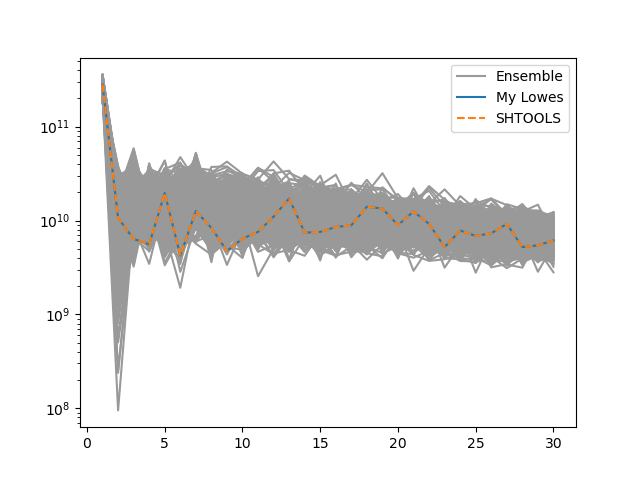

In [4]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

# g ensemble and parameters
g_core_ens = np.genfromtxt("lithosphere_prior/grids/shcoeff_Dynamo/gnm_midpath.dat").T*10**9
g_core_ens = g_core_ens[:mt_util.shc_vec_len(shc_g),:]

a = core.a
c = core.r_cmb
n_max = shc_g

g_cut = g_core_ens[:n_max*(2+n_max),200:] # Truncate g
R = mt_util.lowe_shspec(n_max,c,a,g_cut)

# One spectra for comparison to SHTOOLS
g_cut_one = g_core_ens[:,core.ens_idx][:n_max*(2+n_max)]
R_one = mt_util.lowe_shspec(n_max,c,a,g_cut_one.reshape(-1,1))

# SHTOOLS
ens_cilm_compare = np.array(pyshtools.shio.SHVectorToCilm(np.hstack((np.zeros(1,), g_cut_one))))
p_spec_compare = pyshtools.gravmag.mag_spectrum(ens_cilm_compare, a, c, degrees = np.arange(1,np.shape(ens_cilm_compare)[1]))

# Spectra
plt.figure()
for i in np.arange(R.shape[1]):
    if i == 0:
        plt.semilogy(np.arange(1,n_max+1),R[:,i],color=(0.6,0.6,0.6),label="Ensemble")
    else:
        plt.semilogy(np.arange(1,n_max+1),R[:,i],color=(0.6,0.6,0.6))
plt.semilogy(np.arange(1,n_max+1),R_one,label="My Lowes")
plt.semilogy(np.arange(1,n_max+1),p_spec_compare,linestyle="dashed", label="SHTOOLS")
plt.legend()
plt.show()

# New tapered cov

[]


<IPython.core.display.Javascript object>


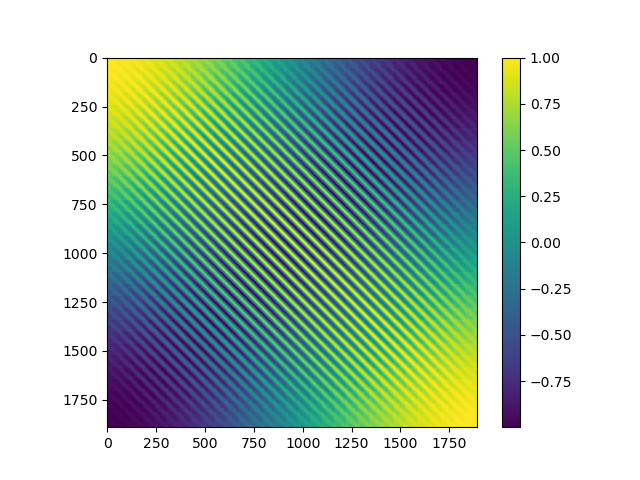

In [5]:
c_angdist = np.cos(mt_util.haversine(1, core.grid_phi.reshape(1,-1), 90-core.grid_theta.reshape(1,-1), 
                              core.grid_phi.reshape(-1,1), 90-core.grid_theta.reshape(-1,1)))

print(c_angdist[c_angdist>1])

plt.figure()
plt.imshow(c_angdist)
plt.colorbar()
plt.show()

In [6]:
tap_to = 500
n_tap = n_max + tap_to

tap_cos = np.cos(np.linspace(0,np.pi,20))+1
tap_cos_norm = ((tap_cos - np.min(tap_cos))/(np.max(tap_cos)-np.min(tap_cos))).reshape(-1,1)

# Compute covariances based on eqn. 11
C_const = (np.arange(1,n_tap+1)+1)/(2*np.arange(1,n_tap+1)+1)

# Pn
Pn = []
for cmu in np.ravel(c_angdist):
    Pn.append(pyshtools.legendre.PlSchmidt(n_tap,cmu)[1:].reshape(-1,1))

Pn = np.array(Pn).reshape((c_angdist.shape[0],c_angdist.shape[1],-1))

# Automate pos def find

<IPython.core.display.Javascript object>


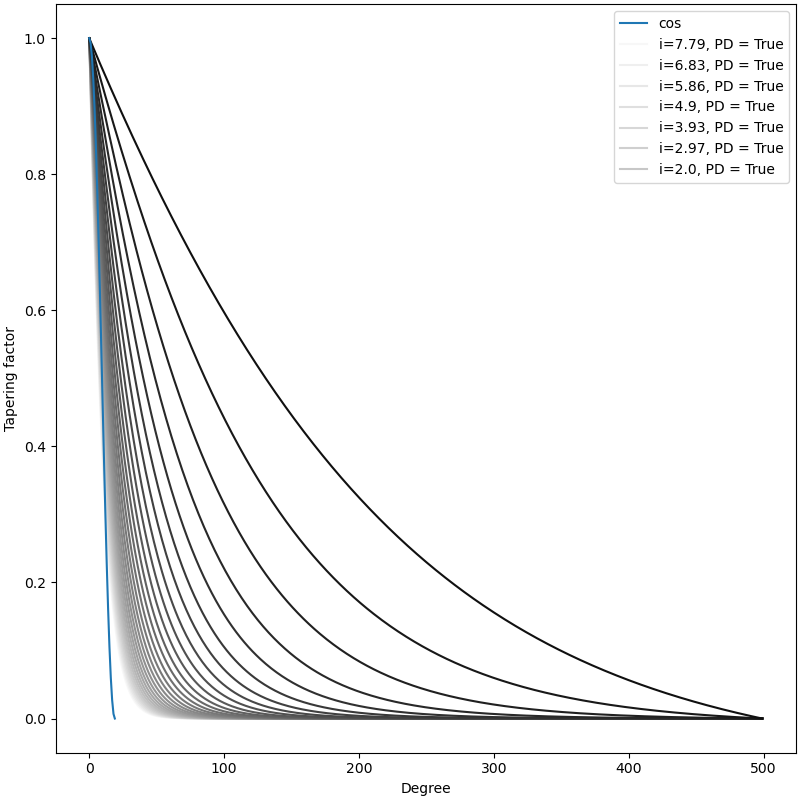

In [20]:
init_lin = 30
N_lin = 30

fig = plt.figure(figsize=(8,8), constrained_layout=True)
gs = fig.add_gridspec(1, 1) 
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(tap_cos_norm,label="cos",zorder=1)
legend_list = ["cos"]
ax1.legend(legend_list)
ax1.set_xlabel('Degree')
ax1.set_ylabel('Tapering factor')
fig.canvas.draw()

try_lin = np.flip(np.round(np.linspace(2,init_lin,N_lin),decimals=2))

for i in try_lin:
    lin_tanh = np.linspace(0.5,i,tap_to)
    tap_tanh = -(np.exp(lin_tanh)-np.exp(-lin_tanh))/(np.exp(lin_tanh)+np.exp(-lin_tanh))
    tap_tanh_norm = ((tap_tanh - np.min(tap_tanh))/(np.max(tap_tanh)-np.min(tap_tanh))).reshape(-1,1)

    #R_add = 0.1*R[-1,:]*tap_tanh_norm
    R_add = np.ones((R[-1,:].shape))*tap_tanh_norm
    R_tap = np.vstack((R,R_add))

    C_Br = Pn@(C_const.reshape(-1,1)*R_tap)

    C_Br_model = C_Br[:,:,core.ens_idx]
    
    PD = is_pos_def(C_Br_model)
    
    # update plot
    ax1.plot(tap_tanh_norm, color = (i/(init_lin+1),i/(init_lin+1),i/(init_lin+1)),zorder=0)
    if PD:
        legend_list.append('i={}, PD = {}'.format(np.round(i,decimals=2),PD))
    ax1.legend(legend_list)
    
    fig.canvas.draw()
    time.sleep(0.01)

<IPython.core.display.Javascript object>


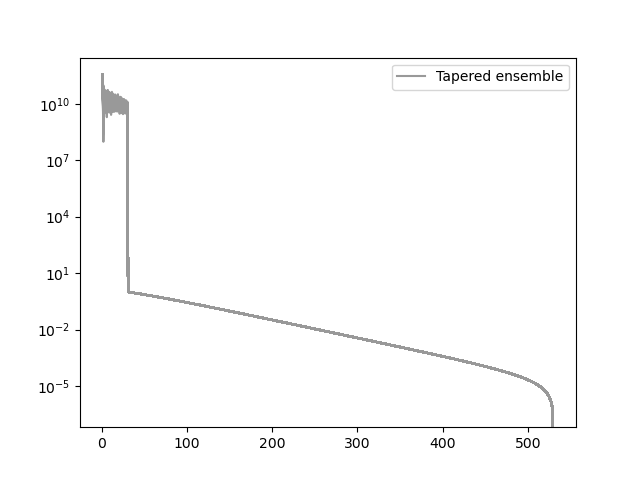

PD:  True


In [13]:
lin_tanh = np.linspace(0.5,6,tap_to)
tap_tanh = -(np.exp(lin_tanh)-np.exp(-lin_tanh))/(np.exp(lin_tanh)+np.exp(-lin_tanh))
tap_tanh_norm = ((tap_tanh - np.min(tap_tanh))/(np.max(tap_tanh)-np.min(tap_tanh))).reshape(-1,1)

#R_add = 0.000001*R[-1,:]*tap_tanh_norm
R_add = np.ones((R[-1,:].shape))*tap_tanh_norm
R_tap = np.vstack((R,R_add))

# Spectra
plt.figure()
for i in np.arange(R_tap.shape[1]):
    if i == 0:
        plt.semilogy(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6),label="Tapered ensemble")
        #plt.plot(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6),label="Tapered ensemble")
    else:
        plt.semilogy(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6))
        #plt.plot(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6))
plt.legend()
plt.show()

C_Br = Pn@(C_const.reshape(-1,1)*R_tap)

C_Br_model = C_Br[:,:,core.ens_idx]

PD = is_pos_def(C_Br_model)
print("PD: ", PD)

<IPython.core.display.Javascript object>


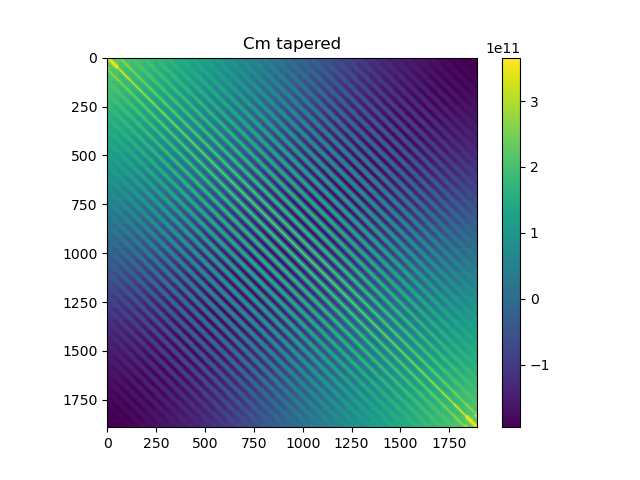

C_Br_model is pos def: True
All eigenvalues > 0: True
Number of negative eigenvalues: 0 / 1891


<IPython.core.display.Javascript object>


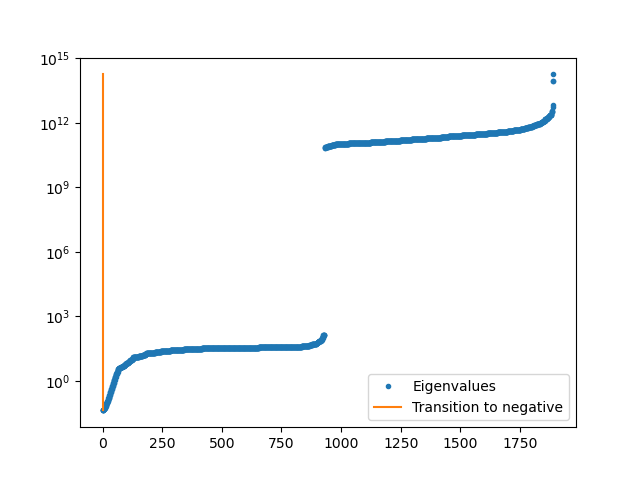

In [14]:
plt.figure()
plt.title("Cm tapered")
plt.imshow(C_Br_model)
plt.colorbar()
plt.show()

# Positive definite covariance?
core_eigval = spl.eigh(C_Br_model, eigvals_only=True)
N_neg_eigval = len(core_eigval[core_eigval<=0])
print("C_Br_model is pos def:", is_pos_def(C_Br_model))
print("All eigenvalues > 0:", np.all(core_eigval>=0))
print("Number of negative eigenvalues:",N_neg_eigval,"/",len(core_eigval))

plt.figure()
plt.semilogy(np.arange(0,len(core_eigval)),core_eigval,'.',label="Eigenvalues")
plt.semilogy(np.ones((100,))*N_neg_eigval,np.linspace(core_eigval[N_neg_eigval],core_eigval[-1],100),label="Transition to negative")
plt.legend()
plt.show()

# Synthetic sat

In [15]:
C_e_const = 2.0

s_sat = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)

s_sat.load_swarm("A")

grid_in = np.array([s_sat.grid_phi, 90-s_sat.grid_theta]).T
s_sat.make_grid(s_sat.grid_radial, grid_in, calc_sph_d = False)

s_sat.generate_map(grid_type = "swarm")

s_sat.data += np.random.normal(scale = C_e_const, size = s_sat.data.shape)

# Source truth

In [16]:
s_source = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)

s_source.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([s_source.grid_phi, 90-s_source.grid_theta]).T
s_source.make_grid(s_source.r_cmb, grid_in, calc_sph_d = False)

s_source.generate_map()

# System equations

In [17]:
core.integrating_kernel(s_sat, C_e_const = C_e_const, C_mm_supply = C_Br_model)

# SDSSIM

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 3.210 minutes 
Total elapsed time: 3.210 minutes 
Variance: 566207157939.851
Mean: 26231.270
Max: 2273556.856
Min: -2015633.916
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.831 minutes 
Total elapsed time: 6.041 minutes 
Variance: 207334662241.050
Mean: 5823.581
Max: 1436101.855
Min: -1837869.967
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 2.740 minutes 
Total elapsed time: 8.781 minutes 
Variance: 361688809452.220
Mean: 45337.248
Max: 1864433.903
Min: -2100178.327
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.690 minutes 
Total elapsed time: 11.471 minutes 
Variance: 338263330065.619
Mean: 24002.621
Max: 1722408.684
Min: -1749202.886
Run nr.: 4

 |OOOOOOOOOO| 100.0%   realization n

 |OOOOOOOOOO| 100.0%   realization nr. 34. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.497 minutes 
Total elapsed time: 1.541 hours 
Variance: 192228819541.412
Mean: 17790.884
Max: 1385072.647
Min: -1481186.837
Run nr.: 35

 |OOOOOOOOOO| 100.0%   realization nr. 35. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 2.456 minutes 
Total elapsed time: 1.582 hours 
Variance: 387971181530.471
Mean: 26055.232
Max: 2076794.399
Min: -1987022.590
Run nr.: 36

 |OOOOOOOOOO| 100.0%   realization nr. 36. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.442 minutes 
Total elapsed time: 1.623 hours 
Variance: 198321738772.943
Mean: 21114.582
Max: 1570740.612
Min: -1826724.665
Run nr.: 37

 |OOOOOOOOOO| 100.0%   realization nr. 37. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.896 minutes 
Total elapsed time: 1.671 hours 
Variance: 213872811415.731
Mean: 28536.758
Max: 1732044.336
Min: -1457445.969
Run nr.: 38

 |OOOOOOOOOO| 100.0%   realization n

 |OOOOOOOOOO| 100.0%   realization nr. 68. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.531 minutes 
Total elapsed time: 3.029 hours 
Variance: 670672737578.114
Mean: -23338.095
Max: 2297895.588
Min: -2138986.056
Run nr.: 69

 |OOOOOOOOOO| 100.0%   realization nr. 69. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 2.810 minutes 
Total elapsed time: 3.076 hours 
Variance: 386391026121.085
Mean: -17230.331
Max: 2069814.015
Min: -2223618.074
Run nr.: 70

 |OOOOOOOOOO| 100.0%   realization nr. 70. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 2.788 minutes 
Total elapsed time: 3.122 hours 
Variance: 310998966615.904
Mean: -9464.184
Max: 1675413.981
Min: -1615967.618
Run nr.: 71

 |OOOOOOOOOO| 100.0%   realization nr. 71. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.884 minutes 
Total elapsed time: 3.170 hours 
Variance: 367202560248.764
Mean: -757.169
Max: 1854507.219
Min: -2235094.756
Run nr.: 72

 |OOOOOOOOOO| 100.0%   realization 

 |OOOOOOOOOO| 100.0%   realization nr. 102. Counter: 1891/1891, Running error magnitude: 5.9
Run time: 2.867 minutes 
Total elapsed time: 4.610 hours 
Variance: 664406159914.532
Mean: -23519.762
Max: 2408580.456
Min: -2128777.840
Run nr.: 103

 |OOOOOOOOOO| 100.0%   realization nr. 103. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 3.003 minutes 
Total elapsed time: 4.661 hours 
Variance: 588202849904.257
Mean: -15862.242
Max: 2135394.601
Min: -2152816.155
Run nr.: 104

 |OOOOOOOOOO| 100.0%   realization nr. 104. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 2.758 minutes 
Total elapsed time: 4.706 hours 
Variance: 294500298464.049
Mean: -27185.300
Max: 1834857.433
Min: -2229770.811
Run nr.: 105

 |OOOOOOOOOO| 100.0%   realization nr. 105. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.478 minutes 
Total elapsed time: 4.748 hours 
Variance: 343669552879.996
Mean: -433.747
Max: 1510763.884
Min: -1628935.733
Run nr.: 106

 |OOOOOOOOOO| 100.0%   rea

 |OOOOOOOOOO| 100.0%   realization nr. 136. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 2.052 minutes 
Total elapsed time: 5.802 hours 
Variance: 239465205900.421
Mean: -2181.034
Max: 1850457.024
Min: -1906489.818
Run nr.: 137

 |OOOOOOOOOO| 100.0%   realization nr. 137. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 2.096 minutes 
Total elapsed time: 5.837 hours 
Variance: 271093515213.473
Mean: 28015.274
Max: 1881011.372
Min: -1807690.787
Run nr.: 138

 |OOOOOOOOOO| 100.0%   realization nr. 138. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.984 minutes 
Total elapsed time: 5.870 hours 
Variance: 259570594075.294
Mean: -1418.999
Max: 1884828.238
Min: -2239566.512
Run nr.: 139

 |OOOOOOOOOO| 100.0%   realization nr. 139. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.345 minutes 
Total elapsed time: 5.909 hours 
Variance: 347998318553.823
Mean: -8796.111
Max: 1933206.565
Min: -1882105.215
Run nr.: 140

 |OOOOOOOOOO| 100.0%   reali

 |OOOOOOOOOO| 100.0%   realization nr. 170. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 2.679 minutes 
Total elapsed time: 7.153 hours 
Variance: 367387922816.232
Mean: 19921.685
Max: 1985465.946
Min: -1807386.383
Run nr.: 171

 |OOOOOOOOOO| 100.0%   realization nr. 171. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 2.434 minutes 
Total elapsed time: 7.194 hours 
Variance: 340484636711.456
Mean: 14304.949
Max: 1950022.771
Min: -2218027.970
Run nr.: 172

 |OOOOOOOOOO| 100.0%   realization nr. 172. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.582 minutes 
Total elapsed time: 7.237 hours 
Variance: 253157885965.938
Mean: -12243.585
Max: 1554233.963
Min: -2146104.390
Run nr.: 173

 |OOOOOOOOOO| 100.0%   realization nr. 173. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.547 minutes 
Total elapsed time: 7.279 hours 
Variance: 172465386860.641
Mean: 17338.150
Max: 1501038.279
Min: -1614747.376
Run nr.: 174

 |OOOOOOOOOO| 100.0%   real

 |OOOOOOOOOO| 100.0%   realization nr. 204. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 2.402 minutes 
Total elapsed time: 8.529 hours 
Variance: 261345458273.330
Mean: -53254.480
Max: 1940744.890
Min: -1371659.429
Run nr.: 205

 |OOOOOOOOOO| 100.0%   realization nr. 205. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 2.189 minutes 
Total elapsed time: 8.566 hours 
Variance: 205658253208.338
Mean: -7470.869
Max: 1447428.621
Min: -1285351.897
Run nr.: 206

 |OOOOOOOOOO| 100.0%   realization nr. 206. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.244 minutes 
Total elapsed time: 8.603 hours 
Variance: 219630847664.077
Mean: 24259.897
Max: 1485647.701
Min: -1734382.147
Run nr.: 207

 |OOOOOOOOOO| 100.0%   realization nr. 207. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.252 minutes 
Total elapsed time: 8.640 hours 
Variance: 271980806024.872
Mean: -6380.128
Max: 1447195.252
Min: -1583225.442
Run nr.: 208

 |OOOOOOOOOO| 100.0%   real

 |OOOOOOOOOO| 100.0%   realization nr. 238. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.612 minutes 
Total elapsed time: 9.928 hours 
Variance: 202818301358.026
Mean: -5387.104
Max: 1998696.077
Min: -2024499.944
Run nr.: 239

 |OOOOOOOOOO| 100.0%   realization nr. 239. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.661 minutes 
Total elapsed time: 9.972 hours 
Variance: 189899723104.030
Mean: -28518.901
Max: 1649356.188
Min: -1486806.453
Run nr.: 240

 |OOOOOOOOOO| 100.0%   realization nr. 240. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.155 minutes 
Total elapsed time: 10.008 hours 
Variance: 225475998430.850
Mean: -4450.007
Max: 1550728.195
Min: -1618329.222
Run nr.: 241

 |OOOOOOOOOO| 100.0%   realization nr. 241. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 2.197 minutes 
Total elapsed time: 10.044 hours 
Variance: 251518284797.429
Mean: -14488.463
Max: 1710720.837
Min: -1456805.523
Run nr.: 242

 |OOOOOOOOOO| 100.0%   r

 |OOOOOOOOOO| 100.0%   realization nr. 272. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.175 minutes 
Total elapsed time: 11.219 hours 
Variance: 211144775458.437
Mean: -8706.657
Max: 1430104.325
Min: -1503559.302
Run nr.: 273

 |OOOOOOOOOO| 100.0%   realization nr. 273. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.435 minutes 
Total elapsed time: 11.259 hours 
Variance: 247761922137.523
Mean: 37580.497
Max: 1858628.307
Min: -1793112.391
Run nr.: 274

 |OOOOOOOOOO| 100.0%   realization nr. 274. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.136 minutes 
Total elapsed time: 11.295 hours 
Variance: 174959087962.763
Mean: -28311.270
Max: 1273386.995
Min: -1465887.686
Run nr.: 275

 |OOOOOOOOOO| 100.0%   realization nr. 275. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.139 minutes 
Total elapsed time: 11.330 hours 
Variance: 166188534195.775
Mean: 11893.913
Max: 1533844.518
Min: -1216833.918
Run nr.: 276

 |OOOOOOOOOO| 100.0%   

 |OOOOOOOOOO| 100.0%   realization nr. 306. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.189 minutes 
Total elapsed time: 12.553 hours 
Variance: 265786082496.377
Mean: -8351.130
Max: 1858929.798
Min: -1325607.658
Run nr.: 307

 |OOOOOOOOOO| 100.0%   realization nr. 307. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.314 minutes 
Total elapsed time: 12.591 hours 
Variance: 482443978211.981
Mean: -40775.739
Max: 1990115.317
Min: -2091981.153
Run nr.: 308

 |OOOOOOOOOO| 100.0%   realization nr. 308. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.177 minutes 
Total elapsed time: 12.627 hours 
Variance: 321816832415.438
Mean: 23831.158
Max: 1797859.816
Min: -1907016.789
Run nr.: 309

 |OOOOOOOOOO| 100.0%   realization nr. 309. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.432 minutes 
Total elapsed time: 12.668 hours 
Variance: 182487611564.028
Mean: -29975.442
Max: 1573532.251
Min: -1417781.750
Run nr.: 310

 |OOOOOOOOOO| 100.0%  

 |OOOOOOOOOO| 100.0%   realization nr. 340. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 2.285 minutes 
Total elapsed time: 13.962 hours 
Variance: 299657855115.124
Mean: 28992.048
Max: 1961818.382
Min: -1945998.714
Run nr.: 341

 |OOOOOOOOOO| 100.0%   realization nr. 341. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.170 minutes 
Total elapsed time: 13.998 hours 
Variance: 450403272752.791
Mean: -8305.365
Max: 1844086.971
Min: -2081804.756
Run nr.: 342

 |OOOOOOOOOO| 100.0%   realization nr. 342. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 2.157 minutes 
Total elapsed time: 14.034 hours 
Variance: 287992005915.314
Mean: -12005.649
Max: 1656569.091
Min: -1552093.574
Run nr.: 343

 |OOOOOOOOOO| 100.0%   realization nr. 343. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.221 minutes 
Total elapsed time: 14.071 hours 
Variance: 205544861524.120
Mean: 33674.439
Max: 1563974.643
Min: -1606509.473
Run nr.: 344

 |OOOOOOOOOO| 100.0%   

 |OOOOOOOOOO| 100.0%   realization nr. 374. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.205 minutes 
Total elapsed time: 15.276 hours 
Variance: 218054488937.218
Mean: -17568.471
Max: 2312247.521
Min: -1373542.910
Run nr.: 375

 |OOOOOOOOOO| 100.0%   realization nr. 375. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 2.320 minutes 
Total elapsed time: 15.315 hours 
Variance: 430488831196.434
Mean: -483.425
Max: 2038396.535
Min: -1919929.800
Run nr.: 376

 |OOOOOOOOOO| 100.0%   realization nr. 376. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.380 minutes 
Total elapsed time: 15.354 hours 
Variance: 229885071941.169
Mean: -35202.977
Max: 1967164.988
Min: -1751828.995
Run nr.: 377

 |OOOOOOOOOO| 100.0%   realization nr. 377. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 2.350 minutes 
Total elapsed time: 15.393 hours 
Variance: 393142655918.575
Mean: -10605.585
Max: 2283541.462
Min: -2633439.925
Run nr.: 378

 |OOOOOOOOOO| 100.0%  

 |OOOOOOOOOO| 100.0%   realization nr. 408. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.200 minutes 
Total elapsed time: 16.575 hours 
Variance: 291244593022.350
Mean: 14644.808
Max: 1602462.040
Min: -1963439.162
Run nr.: 409

 |OOOOOOOOOO| 100.0%   realization nr. 409. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 2.183 minutes 
Total elapsed time: 16.611 hours 
Variance: 425919685327.052
Mean: 27154.601
Max: 1910213.316
Min: -2107922.752
Run nr.: 410

 |OOOOOOOOOO| 100.0%   realization nr. 410. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 2.555 minutes 
Total elapsed time: 16.654 hours 
Variance: 394410216841.720
Mean: -49169.277
Max: 1779079.302
Min: -2239124.077
Run nr.: 411

 |OOOOOOOOOO| 100.0%   realization nr. 411. Counter: 1891/1891, Running error magnitude: 5.9
Run time: 2.442 minutes 
Total elapsed time: 16.694 hours 
Variance: 704483631515.183
Mean: 21717.795
Max: 2054951.125
Min: -2205257.551
Run nr.: 412

 |OOOOOOOOOO| 100.0%   

 |OOOOOOOOOO| 100.0%   realization nr. 442. Counter: 1891/1891, Running error magnitude: 5.9
Run time: 2.144 minutes 
Total elapsed time: 17.856 hours 
Variance: 501545938736.804
Mean: 2940.639
Max: 2184963.867
Min: -2231855.561
Run nr.: 443

 |OOOOOOOOOO| 100.0%   realization nr. 443. Counter: 1891/1891, Running error magnitude: 5.9
Run time: 2.435 minutes 
Total elapsed time: 17.896 hours 
Variance: 609126974076.413
Mean: -9376.583
Max: 2074376.851
Min: -2107149.655
Run nr.: 444

 |OOOOOOOOOO| 100.0%   realization nr. 444. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.199 minutes 
Total elapsed time: 17.933 hours 
Variance: 219672209917.984
Mean: 26907.319
Max: 1443930.278
Min: -1372318.348
Run nr.: 445

 |OOOOOOOOOO| 100.0%   realization nr. 445. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.332 minutes 
Total elapsed time: 17.972 hours 
Variance: 266833936867.494
Mean: 8827.627
Max: 1853573.376
Min: -1683826.935
Run nr.: 446

 |OOOOOOOOOO| 100.0%   rea

 |OOOOOOOOOO| 100.0%   realization nr. 476. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.311 minutes 
Total elapsed time: 19.130 hours 
Variance: 279562087140.307
Mean: -5511.960
Max: 1754825.375
Min: -2038547.168
Run nr.: 477

 |OOOOOOOOOO| 100.0%   realization nr. 477. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.316 minutes 
Total elapsed time: 19.168 hours 
Variance: 227002338587.883
Mean: -6102.010
Max: 1931320.470
Min: -1873326.791
Run nr.: 478

 |OOOOOOOOOO| 100.0%   realization nr. 478. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 2.346 minutes 
Total elapsed time: 19.207 hours 
Variance: 241317500020.347
Mean: -815.166
Max: 1442719.378
Min: -1723364.315
Run nr.: 479

 |OOOOOOOOOO| 100.0%   realization nr. 479. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.462 minutes 
Total elapsed time: 19.248 hours 
Variance: 217243720217.855
Mean: 12236.956
Max: 1611312.438
Min: -1619435.396
Run nr.: 480

 |OOOOOOOOOO| 100.0%   re

 |OOOOOOOOOO| 100.0%   realization nr. 510. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.174 minutes 
Total elapsed time: 20.433 hours 
Variance: 167222259126.421
Mean: 51953.404
Max: 1466745.303
Min: -1176697.000
Run nr.: 511

 |OOOOOOOOOO| 100.0%   realization nr. 511. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.239 minutes 
Total elapsed time: 20.471 hours 
Variance: 216407545574.360
Mean: -15184.600
Max: 1202656.664
Min: -1638639.354
Run nr.: 512

 |OOOOOOOOOO| 100.0%   realization nr. 512. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.173 minutes 
Total elapsed time: 20.507 hours 
Variance: 295681489591.661
Mean: -13045.774
Max: 1650983.256
Min: -1624989.704
Run nr.: 513

 |OOOOOOOOOO| 100.0%   realization nr. 513. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.337 minutes 
Total elapsed time: 20.546 hours 
Variance: 269905764057.621
Mean: 23259.655
Max: 1856350.102
Min: -1621856.102
Run nr.: 514

 |OOOOOOOOOO| 100.0%  

 |OOOOOOOOOO| 100.0%   realization nr. 544. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.163 minutes 
Total elapsed time: 21.715 hours 
Variance: 242105283808.744
Mean: 1377.545
Max: 1949289.694
Min: -1502126.145
Run nr.: 545

 |OOOOOOOOOO| 100.0%   realization nr. 545. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.169 minutes 
Total elapsed time: 21.751 hours 
Variance: 217352170687.625
Mean: -21781.904
Max: 1749094.160
Min: -1962020.863
Run nr.: 546

 |OOOOOOOOOO| 100.0%   realization nr. 546. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 2.238 minutes 
Total elapsed time: 21.788 hours 
Variance: 335897887142.992
Mean: -40885.513
Max: 1884203.818
Min: -1908426.270
Run nr.: 547

 |OOOOOOOOOO| 100.0%   realization nr. 547. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.196 minutes 
Total elapsed time: 21.825 hours 
Variance: 203383200140.958
Mean: -2310.252
Max: 1789276.057
Min: -1534213.790
Run nr.: 548

 |OOOOOOOOOO| 100.0%   

 |OOOOOOOOOO| 100.0%   realization nr. 578. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 2.190 minutes 
Total elapsed time: 22.998 hours 
Variance: 436792354776.182
Mean: -11795.045
Max: 1972039.865
Min: -2366066.997
Run nr.: 579

 |OOOOOOOOOO| 100.0%   realization nr. 579. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.285 minutes 
Total elapsed time: 23.037 hours 
Variance: 209606453735.385
Mean: 15246.751
Max: 1903558.097
Min: -1540862.457
Run nr.: 580

 |OOOOOOOOOO| 100.0%   realization nr. 580. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.154 minutes 
Total elapsed time: 23.072 hours 
Variance: 331228589968.817
Mean: -8984.995
Max: 1977317.379
Min: -2074788.662
Run nr.: 581

 |OOOOOOOOOO| 100.0%   realization nr. 581. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 2.214 minutes 
Total elapsed time: 23.109 hours 
Variance: 365890304111.359
Mean: -23968.944
Max: 1807503.820
Min: -2083073.180
Run nr.: 582

 |OOOOOOOOOO| 100.0%  

 |OOOOOOOOOO| 100.0%   realization nr. 612. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 2.278 minutes 
Total elapsed time: 24.277 hours 
Variance: 276913372939.116
Mean: -34733.064
Max: 1684476.570
Min: -2047599.791
Run nr.: 613

 |OOOOOOOOOO| 100.0%   realization nr. 613. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.196 minutes 
Total elapsed time: 24.314 hours 
Variance: 183461806797.482
Mean: 2783.392
Max: 1417049.144
Min: -1415349.837
Run nr.: 614

 |OOOOOOOOOO| 100.0%   realization nr. 614. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.349 minutes 
Total elapsed time: 24.353 hours 
Variance: 197345877634.621
Mean: 8119.807
Max: 1800547.161
Min: -1347266.797
Run nr.: 615

 |OOOOOOOOOO| 100.0%   realization nr. 615. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.174 minutes 
Total elapsed time: 24.389 hours 
Variance: 209558359173.924
Mean: 33423.122
Max: 1730147.995
Min: -1738781.736
Run nr.: 616

 |OOOOOOOOOO| 100.0%   re

 |OOOOOOOOOO| 100.0%   realization nr. 646. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.156 minutes 
Total elapsed time: 25.538 hours 
Variance: 336358554383.187
Mean: 8102.990
Max: 1824300.455
Min: -2010366.844
Run nr.: 647

 |OOOOOOOOOO| 100.0%   realization nr. 647. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.145 minutes 
Total elapsed time: 25.574 hours 
Variance: 312427308957.279
Mean: -823.691
Max: 1910269.895
Min: -1852713.308
Run nr.: 648

 |OOOOOOOOOO| 100.0%   realization nr. 648. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 2.493 minutes 
Total elapsed time: 25.615 hours 
Variance: 290237976247.544
Mean: -4138.503
Max: 1847334.359
Min: -1955055.887
Run nr.: 649

 |OOOOOOOOOO| 100.0%   realization nr. 649. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 2.192 minutes 
Total elapsed time: 25.652 hours 
Variance: 518998482402.083
Mean: -34890.635
Max: 1991952.846
Min: -1915756.027
Run nr.: 650

 |OOOOOOOOOO| 100.0%   re

 |OOOOOOOOOO| 100.0%   realization nr. 680. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.167 minutes 
Total elapsed time: 26.813 hours 
Variance: 244877001859.884
Mean: 8688.659
Max: 1877055.814
Min: -1967207.291
Run nr.: 681

 |OOOOOOOOOO| 100.0%   realization nr. 681. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 2.271 minutes 
Total elapsed time: 26.851 hours 
Variance: 212757281652.372
Mean: -21473.594
Max: 1611582.735
Min: -2041195.437
Run nr.: 682

 |OOOOOOOOOO| 100.0%   realization nr. 682. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.136 minutes 
Total elapsed time: 26.886 hours 
Variance: 164627750016.212
Mean: 4341.123
Max: 1473485.741
Min: -1373867.029
Run nr.: 683

 |OOOOOOOOOO| 100.0%   realization nr. 683. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.136 minutes 
Total elapsed time: 26.922 hours 
Variance: 320106282719.220
Mean: 14816.820
Max: 1913621.022
Min: -2237962.365
Run nr.: 684

 |OOOOOOOOOO| 100.0%   re

 |OOOOOOOOOO| 100.0%   realization nr. 714. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 2.179 minutes 
Total elapsed time: 28.059 hours 
Variance: 298569292879.114
Mean: -27033.713
Max: 1824113.246
Min: -1867193.333
Run nr.: 715

 |OOOOOOOOOO| 100.0%   realization nr. 715. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 2.640 minutes 
Total elapsed time: 28.103 hours 
Variance: 236028901842.158
Mean: -4544.299
Max: 1534839.659
Min: -1465255.514
Run nr.: 716

 |OOOOOOOOOO| 100.0%   realization nr. 716. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.222 minutes 
Total elapsed time: 28.140 hours 
Variance: 266794135514.434
Mean: -10057.890
Max: 1626028.766
Min: -1701321.329
Run nr.: 717

 |OOOOOOOOOO| 100.0%   realization nr. 717. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 2.147 minutes 
Total elapsed time: 28.176 hours 
Variance: 286902717730.098
Mean: 2212.476
Max: 1848639.120
Min: -2220119.988
Run nr.: 718

 |OOOOOOOOOO| 100.0%   

 |OOOOOOOOOO| 100.0%   realization nr. 748. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.221 minutes 
Total elapsed time: 29.349 hours 
Variance: 250667374006.753
Mean: -44316.452
Max: 1812918.475
Min: -1494251.713
Run nr.: 749

 |OOOOOOOOOO| 100.0%   realization nr. 749. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.184 minutes 
Total elapsed time: 29.385 hours 
Variance: 285188019398.319
Mean: -24080.192
Max: 1945569.405
Min: -1481945.514
Run nr.: 750

 |OOOOOOOOOO| 100.0%   realization nr. 750. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.157 minutes 
Total elapsed time: 29.421 hours 
Variance: 436548019446.086
Mean: -13233.050
Max: 1955196.372
Min: -2025557.538
Run nr.: 751

 |OOOOOOOOOO| 100.0%   realization nr. 751. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.392 minutes 
Total elapsed time: 29.461 hours 
Variance: 244285720316.881
Mean: -17079.854
Max: 1352976.472
Min: -1919543.609
Run nr.: 752

 |OOOOOOOOOO| 100.0%

 |OOOOOOOOOO| 100.0%   realization nr. 782. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 2.403 minutes 
Total elapsed time: 30.623 hours 
Variance: 400718791538.008
Mean: -961.172
Max: 1634028.151
Min: -2158000.577
Run nr.: 783

 |OOOOOOOOOO| 100.0%   realization nr. 783. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 2.198 minutes 
Total elapsed time: 30.660 hours 
Variance: 211928428458.714
Mean: -17481.974
Max: 1446525.122
Min: -1493183.695
Run nr.: 784

 |OOOOOOOOOO| 100.0%   realization nr. 784. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.186 minutes 
Total elapsed time: 30.696 hours 
Variance: 397000704217.810
Mean: 32630.808
Max: 1932898.002
Min: -2112114.341
Run nr.: 785

 |OOOOOOOOOO| 100.0%   realization nr. 785. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.288 minutes 
Total elapsed time: 30.734 hours 
Variance: 441623634483.061
Mean: -15140.226
Max: 1990629.102
Min: -2142405.836
Run nr.: 786

 |OOOOOOOOOO| 100.0%   

 |OOOOOOOOOO| 100.0%   realization nr. 816. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 2.145 minutes 
Total elapsed time: 31.906 hours 
Variance: 456513369579.277
Mean: -24720.525
Max: 1902314.813
Min: -1875330.635
Run nr.: 817

 |OOOOOOOOOO| 100.0%   realization nr. 817. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.256 minutes 
Total elapsed time: 31.944 hours 
Variance: 285626511301.730
Mean: -37163.524
Max: 1789742.633
Min: -2221755.951
Run nr.: 818

 |OOOOOOOOOO| 100.0%   realization nr. 818. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 2.147 minutes 
Total elapsed time: 31.979 hours 
Variance: 253688963560.579
Mean: -28111.557
Max: 1974540.009
Min: -1778128.701
Run nr.: 819

 |OOOOOOOOOO| 100.0%   realization nr. 819. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 2.204 minutes 
Total elapsed time: 32.016 hours 
Variance: 259350543534.848
Mean: -22997.640
Max: 1901053.277
Min: -1526943.623
Run nr.: 820

 |OOOOOOOOOO| 100.0%

 |OOOOOOOOOO| 100.0%   realization nr. 850. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.955 minutes 
Total elapsed time: 33.128 hours 
Variance: 276364893049.821
Mean: -6050.870
Max: 1853803.577
Min: -1718636.992
Run nr.: 851

 |OOOOOOOOOO| 100.0%   realization nr. 851. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.949 minutes 
Total elapsed time: 33.160 hours 
Variance: 222548508659.983
Mean: -16444.196
Max: 1527190.170
Min: -1463284.944
Run nr.: 852

 |OOOOOOOOOO| 100.0%   realization nr. 852. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.954 minutes 
Total elapsed time: 33.193 hours 
Variance: 239538583880.462
Mean: -24475.574
Max: 1786888.946
Min: -1806268.008
Run nr.: 853

 |OOOOOOOOOO| 100.0%   realization nr. 853. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.947 minutes 
Total elapsed time: 33.225 hours 
Variance: 347396784039.857
Mean: 6875.525
Max: 1970491.833
Min: -1749471.481
Run nr.: 854

 |OOOOOOOOOO| 100.0%   

 |OOOOOOOOOO| 100.0%   realization nr. 884. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.947 minutes 
Total elapsed time: 34.231 hours 
Variance: 472248324496.974
Mean: -15775.807
Max: 1989820.532
Min: -2220272.791
Run nr.: 885

 |OOOOOOOOOO| 100.0%   realization nr. 885. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.945 minutes 
Total elapsed time: 34.264 hours 
Variance: 595211551961.104
Mean: 35735.026
Max: 2054443.773
Min: -2000845.536
Run nr.: 886

 |OOOOOOOOOO| 100.0%   realization nr. 886. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 1.942 minutes 
Total elapsed time: 34.296 hours 
Variance: 387604316464.623
Mean: 2001.273
Max: 1917253.327
Min: -2255566.072
Run nr.: 887

 |OOOOOOOOOO| 100.0%   realization nr. 887. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.947 minutes 
Total elapsed time: 34.329 hours 
Variance: 276697677233.971
Mean: 12498.544
Max: 1798204.650
Min: -2108901.258
Run nr.: 888

 |OOOOOOOOOO| 100.0%   r

 |OOOOOOOOOO| 100.0%   realization nr. 918. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.967 minutes 
Total elapsed time: 35.335 hours 
Variance: 219113865520.569
Mean: 7959.423
Max: 1441673.742
Min: -1353715.582
Run nr.: 919

 |OOOOOOOOOO| 100.0%   realization nr. 919. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.948 minutes 
Total elapsed time: 35.368 hours 
Variance: 278262084171.497
Mean: 25875.329
Max: 2004619.374
Min: -2032812.132
Run nr.: 920

 |OOOOOOOOOO| 100.0%   realization nr. 920. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.945 minutes 
Total elapsed time: 35.400 hours 
Variance: 251885940775.658
Mean: -24358.312
Max: 1755405.107
Min: -1598290.980
Run nr.: 921

 |OOOOOOOOOO| 100.0%   realization nr. 921. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.953 minutes 
Total elapsed time: 35.433 hours 
Variance: 243233088099.846
Mean: -34185.924
Max: 1620542.553
Min: -1946827.327
Run nr.: 922

 |OOOOOOOOOO| 100.0%   

 |OOOOOOOOOO| 100.0%   realization nr. 952. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.937 minutes 
Total elapsed time: 36.438 hours 
Variance: 333511705954.532
Mean: -19518.117
Max: 1706955.779
Min: -1877301.378
Run nr.: 953

 |OOOOOOOOOO| 100.0%   realization nr. 953. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.943 minutes 
Total elapsed time: 36.471 hours 
Variance: 287684985567.719
Mean: -8153.137
Max: 1906681.082
Min: -1920303.391
Run nr.: 954

 |OOOOOOOOOO| 100.0%   realization nr. 954. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.946 minutes 
Total elapsed time: 36.503 hours 
Variance: 197023261286.112
Mean: 8822.601
Max: 1293865.800
Min: -1775689.046
Run nr.: 955

 |OOOOOOOOOO| 100.0%   realization nr. 955. Counter: 1891/1891, Running error magnitude: 5.9
Run time: 1.950 minutes 
Total elapsed time: 36.535 hours 
Variance: 415374325215.902
Mean: 6301.480
Max: 2209462.000
Min: -1787729.050
Run nr.: 956

 |OOOOOOOOOO| 100.0%   re

 |OOOOOOOOOO| 100.0%   realization nr. 986. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.958 minutes 
Total elapsed time: 37.541 hours 
Variance: 298390861323.509
Mean: 9231.806
Max: 1865043.259
Min: -1873256.390
Run nr.: 987

 |OOOOOOOOOO| 100.0%   realization nr. 987. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.943 minutes 
Total elapsed time: 37.573 hours 
Variance: 240237183534.992
Mean: 10434.436
Max: 1884732.315
Min: -1808279.249
Run nr.: 988

 |OOOOOOOOOO| 100.0%   realization nr. 988. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.946 minutes 
Total elapsed time: 37.605 hours 
Variance: 576186891539.167
Mean: -12055.664
Max: 2485371.763
Min: -2286003.843
Run nr.: 989

 |OOOOOOOOOO| 100.0%   realization nr. 989. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 1.945 minutes 
Total elapsed time: 37.638 hours 
Variance: 306073141974.088
Mean: 2685.748
Max: 2009219.081
Min: -1820835.018
Run nr.: 990

 |OOOOOOOOOO| 100.0%   re

<IPython.core.display.Javascript object>


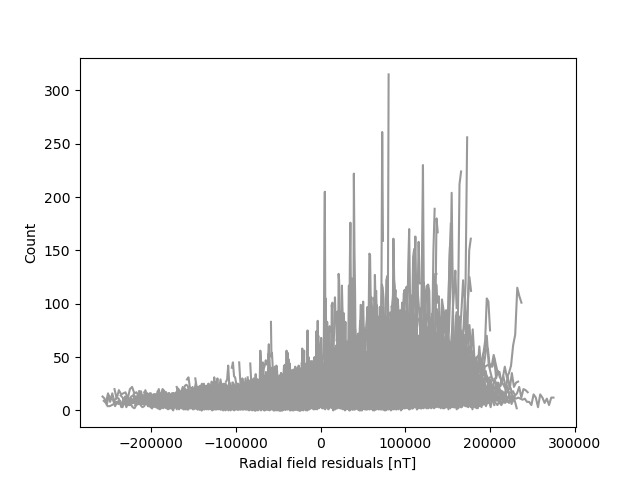

In [18]:
N_sim = 1000
core.target_var = np.max(C_Br_model)
#core.target_var = np.var(core.data)

core.run_sim(N_sim, core.grid_N, core.C_mm_all, core.C_dd, core.C_dm_all, core.G,
        s_sat.data, core.data, scale_m_i = True, unit_d = False, collect_all = True,
        sense_running_error = True, save_string = nb_name, sim_stochastic = True, solve_cho = True)

In [19]:
core.realization_to_sh_coeff(core.r_cmb, set_nmax = shc_grid)

In [20]:
#core.covmod_lsq_equiv(s_sat.data, C_Br_model, core.G, core.r_cmb)

<IPython.core.display.Javascript object>


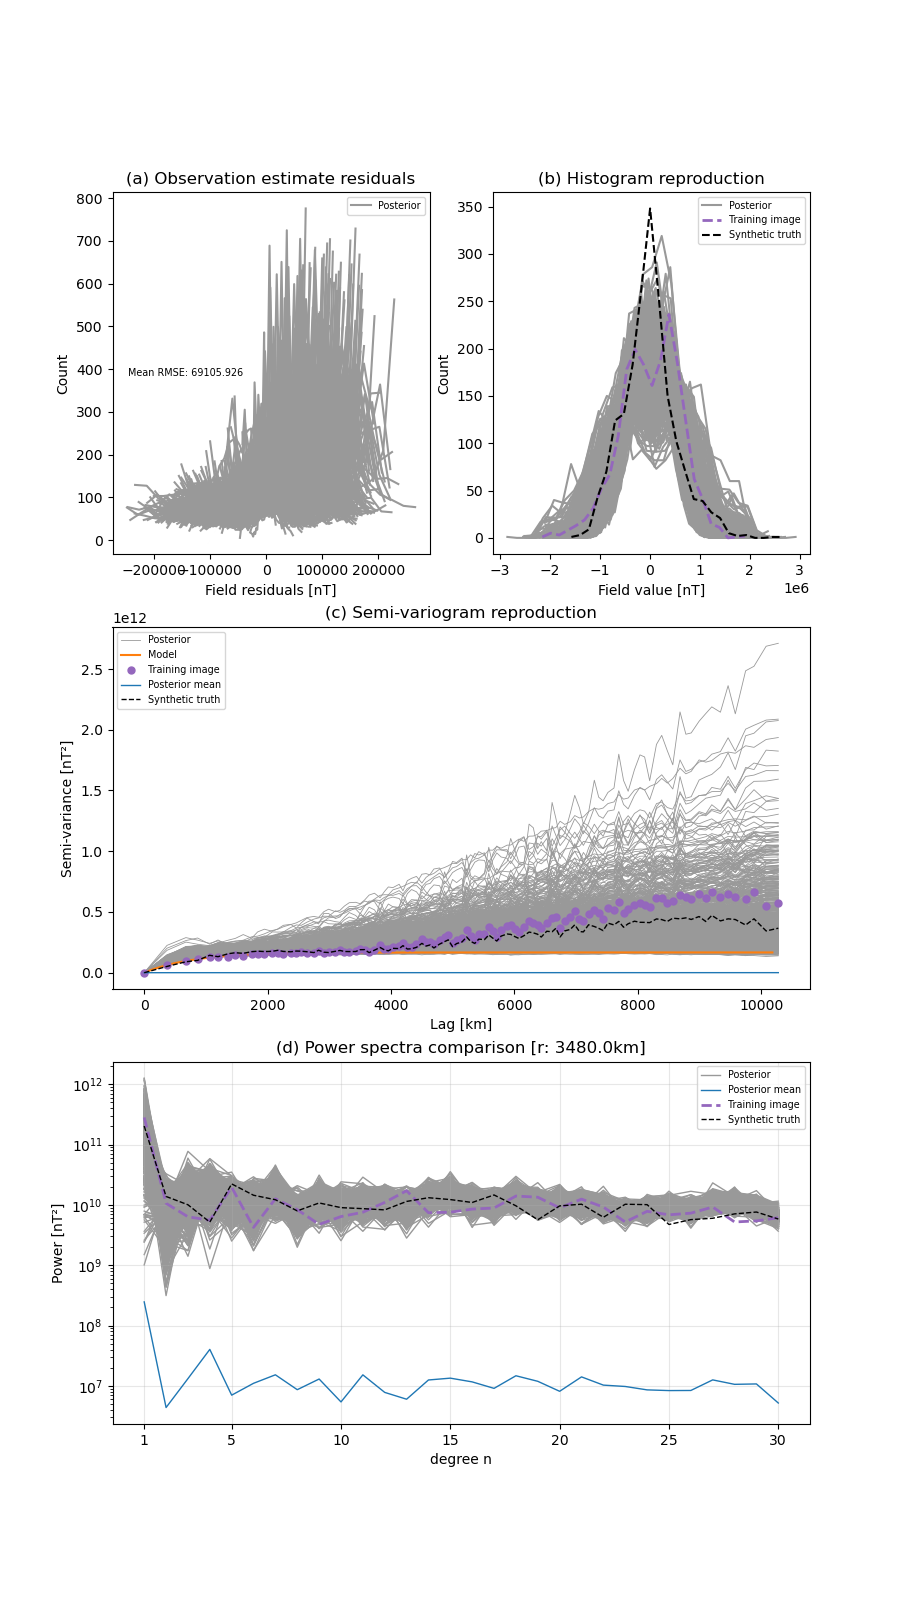

In [21]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = None, truth_obj = s_source,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              model_dict = {}, figsize=(9,16), hist_ti_ens = False, hist_density = False,
                              hist_bins = 25, res_bins = 25, hist_pos_mean = False,
                              savefig = False, save_string = "core_sh30_newTI", save_dpi = 300)

In [22]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)
#core.grid_glq(nmax = 120, r_at = core.r_cmb)

set_nmax = shc_grid

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
core.ensemble_B(s_sat.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
prior_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


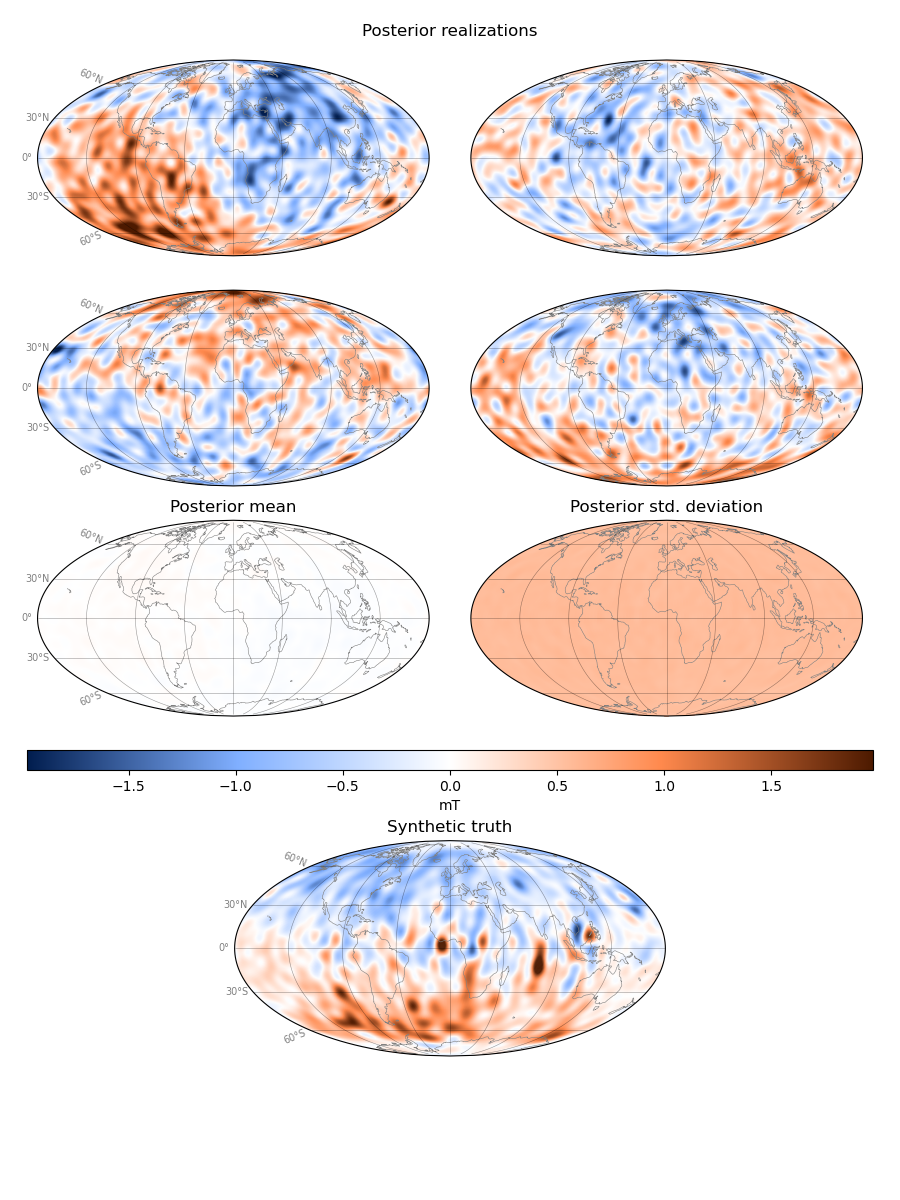

In [23]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa, 
                        field_compare = prior_eqa, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 0.1, cbar_mm_factor = 2/3,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "core_sh30_newTI", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)


<IPython.core.display.Javascript object>


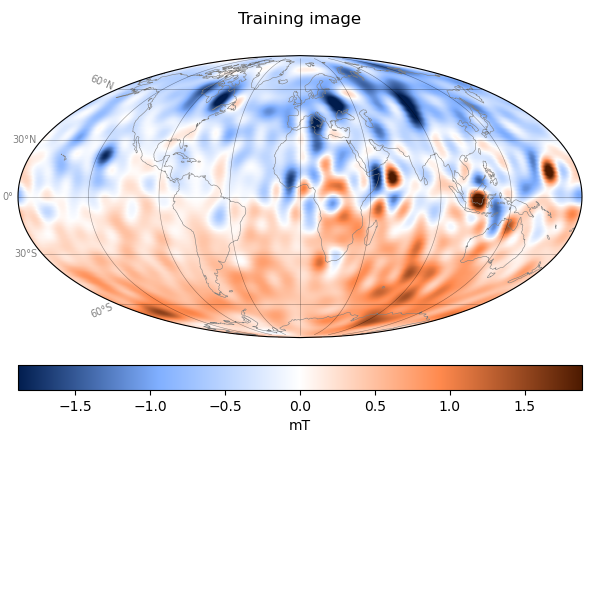

In [79]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
training_image = core.B_ensemble[:,0].copy()

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=training_image, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Training image', point_size=1,
                savefig = False, save_dpi = 100, save_string ="core_sh30_synth_TI",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)